In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import pyarrow.parquet as pq
import pyarrow as pa
#pa.__version__

pd.set_option('display.width', 500)

%matplotlib inline
%load_ext rpy2.ipython
#%R library(lme4)

In [2]:
! pwd

/Users/KAschbacher/Desktop/eheart/analysis/BAC/self_monitoring


In [3]:
from statsmodels.regression.mixed_linear_model import MixedLMResults

In [ ]:
# ### Test Example
# ### --http://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html
# ### -- note: sometimes this works, and other times you get a timeout error - seems to be due to bad internet connection, just rerun

# data = sm.datasets.get_rdataset('dietox', 'geepack').data
# md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
# mdf = md.fit()
# print(mdf.summary())

### Load Parquet file

In [15]:
FOLDER = "/Users/KAschbacher/Desktop/eheart/analysis/BAC/redshift_data"
FILENAME = "bac.final_analysis9_2013_2019-08-10.parquet"
#FIG_FOLDER = "/Users/KAschbacher/Dropbox/BACTrack/BACTrack/Manuscript/Tables and Figures/Bargraphs"
FIG_FOLDER = "/Users/KAschbacher/Dropbox/BACTrack/BACTrack"
TODAY = str(dt.date.today())

In [5]:
def reassemble_date_partitioned_data(folder, filename):
    # parquet files have been saved in a date-partitioned manner (by year) b/c redshift connection was breaking or taking too long during downloads
    
    df_list = []
    prior_year=2013
    for file_year in np.arange(prior_year, 2018):
        try:
            i = filename.find(str(prior_year))
            filename = filename.replace(str(prior_year), str(file_year))# rename file
            prior_year=file_year# advance counter
            
            print ('\nLoading file {}...'.format(filename))
            filepath = '/'.join([folder, filename])
            df = pq.read_table(filepath).to_pandas()
            print ('Dataframe loaded. DF-shape {}'.format(df.shape))
            df_list.append(df)
        except:
            print ('Year {} not found in filename {}'.format(file_year, filename))

    # Ideally, you'd check that the columns match
    master_df = pd.concat(df_list, axis=0, ignore_index=True)
    return master_df

df = reassemble_date_partitioned_data(FOLDER, FILENAME)
print ('\nFinal df has shape: {}'.format(df.shape))
df.head(3)


Loading file bac.final_analysis9_2013_2019-08-10.parquet...


/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Dataframe loaded. DF-shape (42847, 140)

Loading file bac.final_analysis9_2014_2019-08-10.parquet...
Dataframe loaded. DF-shape (94407, 140)

Loading file bac.final_analysis9_2015_2019-08-10.parquet...
Dataframe loaded. DF-shape (414619, 140)

Loading file bac.final_analysis9_2016_2019-08-10.parquet...
Dataframe loaded. DF-shape (268218, 140)

Loading file bac.final_analysis9_2017_2019-08-10.parquet...
Dataframe loaded. DF-shape (153173, 140)

Final df has shape: (973264, 140)


,username,bac_level,bac_guess,bac_level_verified_sum,photo_count,drinks_count,note,timestamp_gmt,timestamp_converted_to_local,timezone,...,gas_tax_per_gal_2014,cig_tax_per_20pack_2014,spirit_tax_per_gal_2014,wine_tax_per_gal_2014,beer_tax_per_gal_2014,guess_number,episode,episode_3hr,episode_6hr,min_since_last_guess
0,iSWQmQGkim-330i00,0.0,0.0,0,0,0,,2013-12-18 05:34:00,2013-12-18 05:34:00,Africa/Accra,...,NaN,NaN,NaN,NaN,NaN,574.0,NaN,NaN,NaN,NaN
1,iSWQmQGkim-332i02,0.0,0.0,0,0,0,,2013-07-22 11:51:00,2013-07-22 11:51:00,Africa/Accra,...,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN
2,iSWQmQGkim-331206,0.0,0.0,0,0,0,,2013-12-25 19:41:00,2013-12-25 19:41:00,Africa/Accra,...,NaN,NaN,NaN,NaN,NaN,412.0,NaN,NaN,NaN,NaN


### Prepare DF for Mixed Model

In [6]:
df.isnull().sum()

username                                     0
bac_level                                    0
bac_guess                                    0
bac_level_verified_sum                       0
photo_count                                  0
drinks_count                                 0
note                                         0
timestamp_gmt                                0
timestamp_converted_to_local            223674
timezone                                     0
timezone_from_geo                            0
latitude                                     0
longitude                                    0
country                                      0
place_name                                   0
population                                   0
elevation                                    0
random_row                                   0
n_bacs_measured                              0
zip_code                                457740
county                                  457740
state_code   

In [7]:
# Fill forward empty cells for Episode
# -- Also, use this as a hack to refine which episode variable to use for the rest of these results
fills = ["episode", "episode_3hr", "episode_6hr"]# note that episode is defined by a 12hr window
fills = [fill+'_ffill' for fill in fills]
for fill in fills:
    df[fill] = df.episode_3hr.fillna(method='ffill')# forward fill

# QA missing data should be the same for all episode variables
df[fills].isnull().sum()
# # BUG CHECK:  If 0 rows, then check was passed
# df.loc[ (df.episode_3hr_ffill.isnull()==False) & (df.episode_ffill.isnull()==True) ].head(10)

episode_ffill        7025
episode_3hr_ffill    7025
episode_6hr_ffill    7025
dtype: int64

In [8]:
def create_regdf(df, cols):
    # copy, dropna, report # rows dropped
    n1 = df.shape[0]
    reg_df = df[cols].copy()
    
    # As of 08-10-2019, this step was done in redshift before calculating episode & min_since_last_guess
    reg_df = reg_df[(reg_df.bac_level>0) | (reg_df.bac_guess>0)]
    n2 = reg_df.shape[0]
    n2users = reg_df.username.unique().shape[0]
    
    reg_df = reg_df.dropna()
    n3 = reg_df.shape[0]
    n3users = reg_df.username.unique().shape[0]
    
    print ('Number of rows nrows excluded: {}\ndropped for missingness: {}\total rows dropped or excluded: {}'.format(n1-n2, n2-n3, n1-n3))
    print ('\nSample size of original df: {}\nreg_df after exclusions: {}\nfinal after drops: {} \nfinal n-users: {}'.format(n1, n2, n3, n3users))
    return reg_df

def add_features(df):
    # Consider that once you aggregate over episode these timestamp extractions mostly aren't meaningful...
    df['abs_guess_delta']=np.abs(df.guess_delta)
    df['verified']=(df.bac_level_verified_sum>0).astype(int)
    df['date'] = df['timestamp_converted_to_local'].dt.date
    df['year'] = df['timestamp_converted_to_local'].dt.year
    df['dow'] = df['timestamp_converted_to_local'].dt.weekday# M=0... Sn=6
    df['hour'] = df['timestamp_converted_to_local'].dt.hour
    return df


cols = ["username", "timestamp_gmt", "bac_level_verified_sum","timestamp_converted_to_local",  
          "min_since_last_guess","guess_number","bac_level", "bac_guess","guess_delta",
          "n_bacs","n_bac_days","days_range_engaged"]
cols.extend(fills)

reg_df = create_regdf(df, cols)
reg_df.sort_values(by=["username","episode_ffill"])

# Add features
reg_df = add_features(reg_df)

reg_df.head(3)

Number of rows nrows excluded: 262649
dropped for missingness: 167069	otal rows dropped or excluded: 429718

Sample size of original df: 973264
reg_df after exclusions: 710615
final after drops: 543546 
final n-users: 27745


,username,timestamp_gmt,bac_level_verified_sum,timestamp_converted_to_local,min_since_last_guess,guess_number,bac_level,bac_guess,guess_delta,n_bacs,...,days_range_engaged,episode_ffill,episode_3hr_ffill,episode_6hr_ffill,abs_guess_delta,verified,date,year,dow,hour
7041,iSWQmQGkim-332G44,2013-07-12 17:18:00,0,2013-07-12 17:18:00,2.0,23.0,0.020,0.0,-0.020,65,...,3.0,2.0,2.0,2.0,0.020,0,2013-07-12,2013,4,17
7042,iSWQmQGkim-33Q3G4,2013-12-21 13:57:00,0,2013-12-21 13:57:00,1.0,27.0,0.044,0.0,-0.044,173,...,232.0,2.0,2.0,2.0,0.044,0,2013-12-21,2013,5,13
7043,iSWQmQGkim-334362,2013-11-22 05:55:00,0,2013-11-22 05:55:00,1.0,38.0,0.149,0.0,-0.149,52,...,153.0,2.0,2.0,2.0,0.149,0,2013-11-22,2013,4,5


### Do people with un-verified observations have higher bac levels, as you might expect?  How much higher?

In [9]:
def get_descriptives(df, dv, group):
    BOLD = '\033[1m'; END = '\033[0m'
    # Get the actual means & se
    means = [m[0] for m in df[[dv, group]].groupby(group).mean().round(3).values]
    stddevs = [s[0] for s in df[[dv, group]].groupby(group).std().round(3).values]
    counts = [c[0] for c in df[[dv, group]].groupby(group).count().round(3).values]
    sems = stddevs/np.sqrt(counts)
    print (BOLD+'\nDescriptives\n','-'*60+END)
    print ('Group: Unverified=0, Verified=1')
    print ('Means: ', means)
    print ('SEMS: ', sems)
    print ('STDDEV: ', stddevs)
    print ('Ns: ', counts)
    print ('-'*60,'\n')

In [10]:
def unverified_analyses(df):
    # Mixed Linear Model to Test this Hypotheis...
    # -- H: If you measure BrAC immediately after drinking, fumes in your mouth spuriously inflate the BrAC reading above what your true blood alcohol level is.
    model = smf.mixedlm('bac_level ~ verified', df, groups='username')
    mdf = model.fit()
    get_descriptives(df=df, dv='bac_level', group='verified')
    return mdf
    
mdf = unverified_analyses(reg_df)
mdf.summary()

/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Descriptives
 ------------------------------------------------------------
Group: Unverified=0, Verified=1
Means:  [0.09, 0.076]
SEMS:  [2.34434536e-04 9.52127976e-05]
STDDEV:  [0.071, 0.064]
Ns:  [91722, 451824]
------------------------------------------------------------ 



<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: bac_level  
No. Observations: 543546  Method:             REML       
No. Groups:       27745   Scale:              0.0034     
Min. group size:  1       Likelihood:         752088.0296
Max. group size:  2154    Converged:          Yes        
Mean group size:  19.6                                   
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      0.091    0.000 256.905 0.000  0.090  0.091
verified      -0.017    0.000 -52.623 0.000 -0.017 -0.016
username Var   0.001    0.000                            
=========================================================

"""

### Limit to Verified Observations:  Save for BrAC_Discrimination.ipynb (R)

In [11]:
def limit_verified(df, col_name):
    pre = df.shape[0]
    preuser = df.username.unique().shape[0]
    df = df.loc[df[col_name]>0]
    post = df.shape[0]
    postuser = df.username.unique().shape[0]
    print ('Out of {} observations, {} were dropped because they were unverified'.format(pre, pre-post))
    print ('Out of {} unique users, {} were dropped because they were unverified'.format(preuser, preuser-postuser))
    return df

def save_verified(df, folder):
    filename = 'bac_BrAC_Discrimination_{}.csv'.format(TODAY)
    filepath = '/'.join([folder, filename])
    df.to_csv(filepath, sep=',', index=False)
    
reg_df = limit_verified(df=reg_df, col_name='verified')
save_verified(reg_df, FOLDER)

Out of 543546 observations, 91722 were dropped because they were unverified
Out of 27745 unique users, 1040 were dropped because they were unverified


### Limit to the first few episodes of self-monitoring - we should see improvement quickly

new shape of df: (265269, 21)


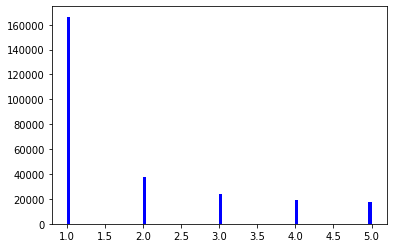

In [12]:
def limit_episodes(df, n_episodes):
    df = df.loc[df.episode_ffill<=n_episodes]
    print ('new shape of df:', df.shape)
    df.episode_ffill.hist(bins=100, color='b')
    plt.grid(False)
    return df

n_episodes = 5
reg_df = limit_episodes(reg_df, n_episodes)

Shape of user-episode aggregated DF: (85257, 6)

     username  episode_ffill  bac_level  guess_delta  abs_guess_delta  episode_ffill_sq
0   RmQkcjj60            1.0     0.0460     0.007333         0.018667               1.0
1   RmQkcjj60            2.0     0.0410     0.024000         0.024000               4.0
2   RmQkcjj60            3.0     0.0275     0.017500         0.017500               9.0


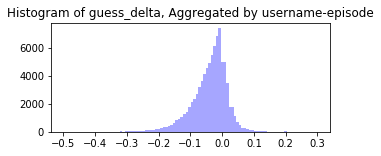

In [13]:
### Aggregate over episode and extract weekend/ hour_binned as features
def define_episode_df(df, cols, episode, var):
    # Aggregate
    epi_df = df[cols].groupby(["username", episode]).mean().reset_index()
    epi_df[episode+'_sq']=epi_df[episode]*epi_df[episode]
    print ('Shape of user-episode aggregated DF: {}\n'.format(epi_df.shape))
    print (epi_df.head(3))
    
    # Plot
    epi_df[var].hist(bins=100, color='b', alpha=.35, figsize=(5,2))
    plt.grid(False)
    plt.title("Histogram of {}, Aggregated by username-episode".format(var))

    return epi_df

cols = ["username","episode_ffill","bac_level","guess_delta","abs_guess_delta"]
epi_df = define_episode_df(df=reg_df, cols=cols, episode="episode_ffill", var="guess_delta")

### Try Mixed Model in BACtrack

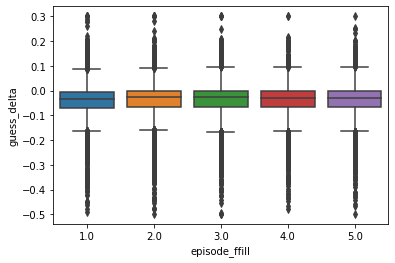

In [14]:
#plt.scatter(epi_df['episode_ffill'], epi_df['guess_delta'])
sns.boxplot(epi_df['episode_ffill'], epi_df['guess_delta'])

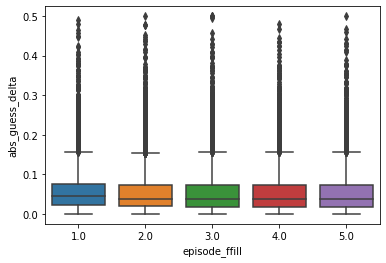

In [15]:
sns.boxplot(epi_df['episode_ffill'], epi_df['abs_guess_delta'])

### Mixed Models:  
#### Hypothesis: BrAC Discrimination improves within the first few episodes of self-monitoring.
<p> We may need to use abs_discrimination so that over- and under-estimates do not cancel each other out</p>
<p> Still considering whether or not to add a quadratic term - while more accurate may lead to convergence issues</p>

In [16]:
# Absolute Guess Delta
md = smf.mixedlm("abs_guess_delta ~ episode_ffill", epi_df, groups=epi_df["username"])
mdf = md.fit()
print(mdf.summary())

/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_guess_delta
No. Observations: 85257   Method:             REML           
No. Groups:       26533   Scale:              0.0016         
Min. group size:  1       Likelihood:         141129.7718    
Max. group size:  5       Converged:          Yes            
Mean group size:  3.2                                        
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          0.056    0.000 164.252 0.000  0.055  0.057
episode_ffill     -0.001    0.000  -7.454 0.000 -0.001 -0.001
Group Var          0.001    0.000                            



Upper -0.177 and lower 0.05 quantiles, given alpha of 0.05
debug lpb {} ubp 0.025 0.975


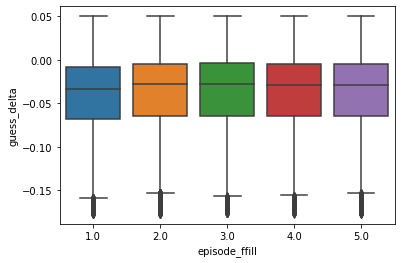

In [17]:
def get_cutpoints(df, alpha):
    # Determine criteria for outliers
    lbp = alpha/2
    ubp = 1-(alpha/2)
    lb = df.guess_delta.quantile(lbp).round(4)
    ub = df.guess_delta.quantile(ubp).round(4)
    print ('Upper {} and lower {} quantiles, given alpha of {}'.format(lb, ub, alpha))
    print ('debug lpb {} ubp', lbp, ubp)
    return lb, ub

# Cut outliers
lb, ub = get_cutpoints(df=epi_df, alpha=.05)
epi_df = epi_df[(epi_df.guess_delta>lb) & (epi_df.guess_delta<ub)]
sns.boxplot(epi_df['episode_ffill'], epi_df['guess_delta'])

In [18]:
md = smf.mixedlm("guess_delta ~ episode_ffill", epi_df, groups=epi_df["username"])
mdf = md.fit()
print(mdf.summary())
print ('N distinct users...',epi_df.username.unique().shape[0])

/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: guess_delta
No. Observations:  80833   Method:             REML       
No. Groups:        26056   Scale:              0.0013     
Min. group size:   1       Likelihood:         140652.8750
Max. group size:   5       Converged:          Yes        
Mean group size:   3.1                                    
----------------------------------------------------------
              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept     -0.040    0.000 -124.969 0.000 -0.041 -0.040
episode_ffill  0.001    0.000    8.382 0.000  0.001  0.001
Group Var      0.001    0.000                             

N distinct users... 26056


## This is probably the right analysis to report in the paper

In [19]:
# Absolute Guess Delta - try it again with the extreme points removed
md = smf.mixedlm("abs_guess_delta ~ episode_ffill", epi_df, groups=epi_df["username"])
mdf = md.fit()
print(mdf.summary())
print ('N distinct users...',epi_df.username.unique().shape[0])

/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_guess_delta
No. Observations: 80833   Method:             REML           
No. Groups:       26056   Scale:              0.0010         
Min. group size:  1       Likelihood:         153377.7198    
Max. group size:  5       Converged:          Yes            
Mean group size:  3.1                                        
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          0.052    0.000 190.919 0.000  0.052  0.053
episode_ffill     -0.002    0.000 -18.809 0.000 -0.002 -0.001
Group Var          0.001    0.000                            

N distinct users... 26056


In [20]:
# Absolute Guess Delta - add a quadratic term
md = smf.mixedlm("abs_guess_delta ~ episode_ffill + episode_ffill_sq", epi_df, groups=epi_df["username"])
mdf = md.fit()#Fit a model in which the fixed effects parameters are penalized
print(mdf.summary())
print ('N distinct users...',epi_df.username.unique().shape[0])

/Users/KAschbacher/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_guess_delta
No. Observations: 80833   Method:             REML           
No. Groups:       26056   Scale:              0.0010         
Min. group size:  1       Likelihood:         153447.2798    
Max. group size:  5       Converged:          Yes            
Mean group size:  3.1                                        
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          0.058    0.001 114.722 0.000  0.057  0.059
episode_ffill     -0.007    0.000 -16.121 0.000 -0.007 -0.006
episode_ffill_sq   0.001    0.000  12.517 0.000  0.001  0.001
Group Var          0.001    0.000                            

N distinct users... 26056


### Bar Plot in Matplotlib

In [21]:
# def get_barplot_data(df, episode, user):
#     print (episode, user)
#     # don't round too much, because it obscures the small but significant differences
#     means = df.groupby(df[episode]).mean().round(6).reset_index()
#     sems = df.groupby(df[episode]).std().round(4).reset_index()/np.sqrt(df.shape[0])
#     counts = df.groupby(df[episode]).count().reset_index().drop(columns=episode)
#     counts = counts.rename(columns={user:'n_observations_per_episode'})
#     ns = [n[0] for n in counts.values]
#     print (means,'\n')
#     print ('Counts: ',ns)
#     return means, sems, ns

# kwargs = {
#     "df":epi_df, 
#     "user":"username", 
#     "episode":"episode_ffill"
# }

# means, sems, ns = get_barplot_data(**kwargs)

# def make_figure(fig, means, sems, ns):
#     ### Define Quantities
#     iv = "abs_guess_delta"
#     xlabel = 'Self-Monitoring Episode'
#     ylabel = "BrAC Discrimination (Abs)"
#     x = means[iv].values
#     y = np.arange(len(x))+1
#     err = sems[iv].values
    
#     ### Define how many episodes to plot.  Default would be length(x)
#     #n_episodes = len(x)
#     n_episodes = 5
    
#     ### Plot Values
#     plt.bar(y[:n_episodes], x[:n_episodes], align='center', alpha=.5, yerr=err[:n_episodes])
#     plt.ylim(.04, .06)
#     plt.xlabel(xlabel, fontsize=14)
#     plt.ylabel(ylabel, fontsize=16)

# fig = plt.figure()
# make_figure(fig, means, sems, ns)

# ### Save Figure (Note, you have to save the figure before you show it; is not necessary to return fig)
# fig_format = "pdf"
# figname = "BrAC_Discrimination_by_Episode_{}.{}".format(TODAY, fig_format)
# figpath = "/".join([FIG_FOLDER, figname])
# plt.savefig(figpath, dpi=600, bbox_inches="tight")
# print ('Figure saved to:\n{}'.format(figpath))
# plt.show()

Figure saved to:
/Users/KAschbacher/Dropbox/BACTrack/BACTrack/BrAC_Discrimination_by_Episode_2021-03-07.pdf


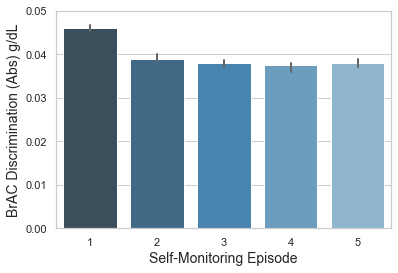

In [32]:
# Try Seaborn bar graph to see if that looks better

xlabel = 'Self-Monitoring Episode'
ylabel = "BrAC Discrimination (Abs) g/dL"
epi_df["episode_ffill"] = epi_df["episode_ffill"].astype(int)

#fig = plt.Figure(figsize=(3,2))# not sure this affects the size here
sns.set(style="whitegrid")
ax = sns.barplot(x="episode_ffill", y="abs_guess_delta", data=epi_df, estimator=np.median, \
                 palette="Blues_d", saturation=.75, ci=95, errcolor=".4", errwidth="2")
plt.xlabel(xlabel, fontsize=14)
plt.ylabel(ylabel, fontsize=14)
plt.ylim(0, .05)

### Save Figure (Note, you have to save the figure before you show it; is not necessary to return fig)
fig_format = "pdf"
figname = "BrAC_Discrimination_by_Episode_{}.{}".format(TODAY, fig_format)
figpath = "/".join([FIG_FOLDER, figname])
plt.savefig(figpath, dpi=600, bbox_inches="tight")
print ('Figure saved to:\n{}'.format(figpath))
plt.show()

In [ ]:
# # https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html
# # -- currently not working
# %R print(summary(lmer('guess_delta ~ episode_ffill', data=epi_df)))

In [17]:
epi_df.head()

,username,episode_ffill,bac_level,guess_delta,abs_guess_delta,episode_ffill_sq
0,RmQkcjj60,1,0.0460,0.007333,0.018667,1.0
1,RmQkcjj60,2,0.0410,0.024000,0.024000,4.0
2,RmQkcjj60,3,0.0275,0.017500,0.017500,9.0
3,RmQkcjj60,4,0.0500,-0.010000,0.010000,16.0
4,RmQkcjj60,5,0.0150,0.015000,0.015000,25.0


In [21]:
cols = ["username", "episode_ffill", "abs_guess_delta"]
user_episode = epi_df[cols].groupby(["username", "episode_ffill"]).mean()

In [23]:
episode = user_episode.groupby("episode_ffill").count()

In [24]:
episode.head(10)

,abs_guess_delta
episode_ffill,
1,25503
2,19292
3,15676
4,13193
5,11593


In [25]:
epi_df.groupby("episode_ffill").count().head(10)

,username,bac_level,guess_delta,abs_guess_delta,episode_ffill_sq
episode_ffill,,,,,
1,25503,25503,25503,25503,25503
2,19292,19292,19292,19292,19292
3,15676,15676,15676,15676,15676
4,13193,13193,13193,13193,13193
5,11593,11593,11593,11593,11593


In [27]:
epi_df.shape

(85257, 6)

In [28]:
epi_df.username.nunique()

26533